**Word Embedding ของ keras**

In [75]:
pip install pythainlp



> Import Package ที่จำเป็น การทำ word embedding ของ keras



In [76]:
import pandas as pd
import re
# from nltk.tokenize import word_tokenize
from pythainlp.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer

from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, LSTM, Bidirectional, Embedding, Dropout, BatchNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.optimizers import Adam

import seaborn as sn
import matplotlib.pyplot as plt

import pickle as p
import plotly
import plotly.graph_objs as go

from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report



> กำหนดจำนวน EPOCHS และ Batch Size


In [77]:
EPOCHS = 150
BS = 32



> เตรียมข้อมูลในการทำ Sentiment Analysis



In [78]:
df = pd.read_csv ('Comments.csv',encoding = "utf-8")

In [79]:
df

,labels,comments
0,pos,ฟังคุณทิมพูด แล้วได้ความรู้เพิ่ม 👏👏
1,pos,ไม่เคยฟังนักการเมืองได้นานขนาดนี้มาก่อนเลย ชื่...
2,pos,ฟังคุณหญิงกับคุณพิธา แล้วรู้สึกมีความหวัง เข้า...
3,pos,เยี่ยม​มาก​ครับ​คุณ​จอมขวัญ ขอบคุณ​สื่อที่กล้า...
4,pos,ขอบคุณคุณพิธาและคุณสุดารัตน์ นี่คือนักวางแผนแล...
...,...,...
495,neg,แหม่​ เอาจำนวนตายจำนวนติดไปเทียบกับประเทศ​ที่ป...
496,neg,รัฐบาลอีโก้สูง มันไม่ฟังอะไรเลยค่ะ
497,neg,มึงตอบได้โคตรผักชีโรยหน้าเลยว่ะ จะเปรียบเทียบก...
498,neg,ไปขุดรมต.มาจากที่ไหน อนาถ


In [80]:
df = df.drop_duplicates()

In [81]:
pos_df = df[df.labels == "pos"].sample(250)
pos_df.head()

,labels,comments
144,pos,อยากได้คุณพิธาเป็นนายก😊
41,pos,คือรอกาชื่อคุณทิมในคูหาเลือกตั้งรอบหน้า (ที่ไม...
45,pos,พิธา เฟี้ยวจังวะ
97,pos,คุณทิมสุดยอด เหมาะสมแล้วหัวหน้าพรรคก้าวไกล ควา...
36,pos,คุณทิม ไม่เคยทำให้ผิดหวัง


In [82]:
neg_df = df[df.labels == "neg"].sample(250)
neg_df.head()

,labels,comments
475,neg,นี่เอารัฐมนตรีมาคุยจริงเหรอครับ ให้เดินไปคุยกะ...
471,neg,ฟังท่าน รมต. แล้ว ท่านเอาประเทศไทยเทียบการได้ร...
328,neg,ใน ครม นี้มีใครฉลาดบ้างวะ ตอนรวม ครม ผ่าตัดเอา...
318,neg,ประเทศไทยฉีดวัคซีนไร้ประสิทธิภาพเป็นอันดับ1 ขอ...
435,neg,รมต นี้พูดไม่มีน้ำหนักเลย ส่วนตัวมีความรู้สึกว...


In [83]:
sentiment_df = pd.concat([neg_df, pos_df])
sentiment_df.head()

,labels,comments
475,neg,นี่เอารัฐมนตรีมาคุยจริงเหรอครับ ให้เดินไปคุยกะ...
471,neg,ฟังท่าน รมต. แล้ว ท่านเอาประเทศไทยเทียบการได้ร...
328,neg,ใน ครม นี้มีใครฉลาดบ้างวะ ตอนรวม ครม ผ่าตัดเอา...
318,neg,ประเทศไทยฉีดวัคซีนไร้ประสิทธิภาพเป็นอันดับ1 ขอ...
435,neg,รมต นี้พูดไม่มีน้ำหนักเลย ส่วนตัวมีความรู้สึกว...


In [84]:
comments = sentiment_df.comments.values
comments.shape

(500,)

In [85]:
comments[0]

'นี่เอารัฐมนตรีมาคุยจริงเหรอครับ ให้เดินไปคุยกะป้าขายอาหารตามสั่งยังรุ้สึกว่าตอบมีสาระ และเหตุผลมากกว่านี้เลย นี่ฟังตรรกะพังพินาศมากเลยเหมือนไม่เคยดูข่าว'

In [86]:
labels = sentiment_df.labels.values
labels.shape

(500,)



> สร้างFunctionต่างๆ เพื่อสร้างTrain Data



In [87]:
def cleaning(sentences):
  words = []
  temp = []
  for s in sentences:
    clean = re.sub(r'[^ก-๙]', "", s)
    w = word_tokenize(clean)
    temp.append([i.lower() for i in w])
    words.append(' '.join(w).lower())
    
  return words, temp

In [88]:
cleaned_words, temp = cleaning(comments)
print(len(cleaned_words))
print(cleaned_words[:5])

500
['นี่ เอา รัฐมนตรี มา คุย จริง เหรอ ครับ ให้ เดิน ไป คุย กะ ป้า ขาย อาหาร ตาม สั่ง ยัง รุ้ สึก ว่า ตอบ มี สาระ และ เหตุผล มากกว่า นี้ เลย นี่ ฟัง ตรรกะ พังพินาศ มาก เลย เหมือน ไม่ เคย ดู ข่าว', 'ฟัง ท่า นร มต แล้ว ท่าน เอา ประเทศ ไทย เทียบ การ ได้รับ วัคซีน กับ อาเซียน เทียบ อัตรา การ เสียชีวิต กับ ทั่วโลก พูด ตามตรง ความคิด ท่าน มัน ห่วยแตก จริงๆ นั่ง ฟัง ท่าน มา เหมือน ท่าน แถ', 'ใน ครม นี้ มี ใคร ฉลาด บ้าง วะ ตอน รวม ครม ผ่าตัด เอา สมอง ออก ก่อน หรอ ถึง จะ เป็น รฐบ ได้', 'ประเทศ ไทย ฉีดวัคซีน ไร้ ประสิทธิภาพ เป็น อันดับ ของ อาเซียน ภูมิใจ มาก ค่า', 'รม ต นี้ พูด ไม่ มี น้ำหนัก เลย ส่วนตัว มีความรู้สึก ว่า ไม่ จริง ความจริงใจ ต่อ ประชาชน ตอบ และ แถ ไป เรื่อยๆ ไม่ มีความหมาย และ ไม่ มี ศัทธา เลย']


In [89]:
def create_tokenizer(words, filters = ''):
    token = Tokenizer(filters=filters)
    token.fit_on_texts(words)
    return token

In [90]:
train_word_tokenizer = create_tokenizer(cleaned_words)
vocab_size = len(train_word_tokenizer.word_index) + 1

train_word_tokenizer.word_index

{'ไม่': 1,
 'คุณ': 2,
 'ที่': 3,
 'มาก': 4,
 'ได้': 5,
 'ครับ': 6,
 'มี': 7,
 'เลย': 8,
 'แล้ว': 9,
 'มา': 10,
 'จอมขวัญ': 11,
 'เป็น': 12,
 'ไป': 13,
 'คน': 14,
 'ค่ะ': 15,
 'ทิม': 16,
 'ให้': 17,
 'แต่': 18,
 'พูด': 19,
 'และ': 20,
 'ฟัง': 21,
 'ว่า': 22,
 'ๆ': 23,
 'ก็': 24,
 'นี้': 25,
 'รัฐบาล': 26,
 'ประชาชน': 27,
 'มัน': 28,
 'จะ': 29,
 'กับ': 30,
 'ของ': 31,
 'ประเทศ': 32,
 'พิธา': 33,
 'รัฐมนตรี': 34,
 'ท่าน': 35,
 'คือ': 36,
 'รม': 37,
 'จริงๆ': 38,
 'ใน': 39,
 'ต': 40,
 'แถ': 41,
 'นะ': 42,
 'เรา': 43,
 'ดี': 44,
 'เก่ง': 45,
 'เขา': 46,
 'รู้': 47,
 'ชอบ': 48,
 'คุณหญิง': 49,
 'เรื่อง': 50,
 'ดู': 51,
 'กัน': 52,
 'อะไร': 53,
 'แบบ': 54,
 'นี่': 55,
 'การ': 56,
 'แบบนี้': 57,
 'นะคะ': 58,
 'ทำ': 59,
 'ต้อง': 60,
 'โง่': 61,
 'นายก': 62,
 'ตอบ': 63,
 'เหมือน': 64,
 'ฉลาด': 65,
 'ทั้ง': 66,
 'ข้อมูล': 67,
 'เอา': 68,
 'จริง': 69,
 'ยัง': 70,
 'ไทย': 71,
 'น่ารัก': 72,
 'เพราะ': 73,
 'อย่าง': 74,
 'ขอบคุณ': 75,
 'เห็น': 76,
 'คิด': 77,
 'รัฐ': 78,
 'อยาก': 79,
 'สุดยอด': 80,
 

In [91]:
def max_length(words):
    return(len(max(words, key = len)))

In [92]:
max_length = max_length(temp)
max_length

65

In [93]:
def encoding_doc(token, words):
    return(token.texts_to_sequences(words))

In [94]:
encoded_doc = encoding_doc(train_word_tokenizer, cleaned_words)

print(cleaned_words[0])
print(encoded_doc[0])

นี่ เอา รัฐมนตรี มา คุย จริง เหรอ ครับ ให้ เดิน ไป คุย กะ ป้า ขาย อาหาร ตาม สั่ง ยัง รุ้ สึก ว่า ตอบ มี สาระ และ เหตุผล มากกว่า นี้ เลย นี่ ฟัง ตรรกะ พังพินาศ มาก เลย เหมือน ไม่ เคย ดู ข่าว
[55, 68, 34, 10, 117, 69, 104, 6, 17, 726, 13, 117, 340, 341, 272, 727, 148, 342, 70, 343, 454, 22, 63, 7, 455, 20, 456, 196, 25, 8, 55, 21, 273, 728, 4, 8, 64, 1, 96, 51, 344]


In [95]:
def padding_doc(encoded_doc, max_length):
    return(pad_sequences(encoded_doc, maxlen = max_length, padding = "post"))

In [96]:
padded_doc = padding_doc(encoded_doc, max_length)
print("Shape of padded docs = ",padded_doc.shape)

print(cleaned_words[0])
print(encoded_doc[0])
print(padded_doc[0])

Shape of padded docs =  (500, 65)
นี่ เอา รัฐมนตรี มา คุย จริง เหรอ ครับ ให้ เดิน ไป คุย กะ ป้า ขาย อาหาร ตาม สั่ง ยัง รุ้ สึก ว่า ตอบ มี สาระ และ เหตุผล มากกว่า นี้ เลย นี่ ฟัง ตรรกะ พังพินาศ มาก เลย เหมือน ไม่ เคย ดู ข่าว
[55, 68, 34, 10, 117, 69, 104, 6, 17, 726, 13, 117, 340, 341, 272, 727, 148, 342, 70, 343, 454, 22, 63, 7, 455, 20, 456, 196, 25, 8, 55, 21, 273, 728, 4, 8, 64, 1, 96, 51, 344]
[ 55  68  34  10 117  69 104   6  17 726  13 117 340 341 272 727 148 342
  70 343 454  22  63   7 455  20 456 196  25   8  55  21 273 728   4   8
  64   1  96  51 344   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0]


In [97]:
unique_labels = list(set(labels))
unique_labels

['neg', 'pos']

In [98]:
output_tokenizer = create_tokenizer(unique_labels)

In [99]:
encoded_output = encoding_doc(output_tokenizer, labels)
print(labels[0:2])
print(encoded_output[0:2])

['neg' 'neg']
[[1], [1]]


In [100]:
encoded_output = np.array(encoded_output).reshape(len(encoded_output), 1)
encoded_output.shape

(500, 1)

In [101]:
def one_hot(encode):
  oh = OneHotEncoder(sparse = False)
  return(oh.fit_transform(encode))

In [102]:
output_one_hot = one_hot(encoded_output)
print(encoded_output[0])
print(output_one_hot[0])

[1]
[1. 0.]




> แบ่งDataset สำหรับ Train 80% และ Validate 20%



In [103]:
train_X, val_X, train_Y, val_Y = train_test_split(padded_doc, output_one_hot, shuffle = True, test_size = 0.2, stratify=output_one_hot)

In [104]:
print("Shape of train_X = %s and train_Y = %s" % (train_X.shape, train_Y.shape))
print("Shape of val_X = %s and val_Y = %s" % (val_X.shape, val_Y.shape))

Shape of train_X = (400, 65) and train_Y = (400, 2)
Shape of val_X = (100, 65) and val_Y = (100, 2)


In [105]:
num_classes = len(unique_labels)



> นิยาม Model แบบ GRU

*   กำหนด learning_rate=0.0001
*   กำหนด dropout = 0.3





In [106]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, LSTM, Bidirectional, Embedding, Dropout, BatchNormalization
from tensorflow.keras.models import load_model

from tensorflow.keras.optimizers import Adam
adam = Adam(learning_rate=0.0001)

def create_model(vocab_size, max_length):
  model = Sequential()
  
  model.add(Embedding(vocab_size, 128, input_length = max_length,  trainable = True))
  model.add(Bidirectional(GRU(128, activation = "relu"))) # activation = "relu"
  model.add(Dense(128, activation = "relu"))
  model.add(Dropout(0.3))
  model.add(Dense(64, activation = "relu"))
  model.add(Dropout(0.3))
  model.add(BatchNormalization())
  model.add(Dense(num_classes, activation = "softmax"))
  
  return model
  
model = create_model(vocab_size, max_length)

In [107]:
model.compile(loss = "categorical_crossentropy", optimizer = adam, metrics = ["accuracy"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 65, 128)           202496    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               198144    
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)               



> สร้างจุด Check Point เพื่อ Save Model



In [108]:
filename = 'model.h5_kr'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')



> Train Model



In [109]:
hist = model.fit(train_X, train_Y, epochs = EPOCHS, batch_size = BS, validation_data = (val_X, val_Y), callbacks = [checkpoint])

Epoch 1/150
13/13 [==============================] - 8s 305ms/step - loss: 0.7094 - accuracy: 0.5000 - val_loss: 0.6917 - val_accuracy: 0.6000

Epoch 00001: val_loss improved from inf to 0.69174, saving model to model.h5_kr
INFO:tensorflow:Assets written to: model.h5_kr/assets
Epoch 2/150
13/13 [==============================] - 4s 284ms/step - loss: 0.6737 - accuracy: 0.5500 - val_loss: 0.6906 - val_accuracy: 0.6300

Epoch 00002: val_loss improved from 0.69174 to 0.69058, saving model to model.h5_kr
INFO:tensorflow:Assets written to: model.h5_kr/assets
Epoch 3/150
13/13 [==============================] - 3s 268ms/step - loss: 0.6508 - accuracy: 0.6275 - val_loss: 0.6892 - val_accuracy: 0.7900

Epoch 00003: val_loss improved from 0.69058 to 0.68923, saving model to model.h5_kr
INFO:tensorflow:Assets written to: model.h5_kr/assets
Epoch 4/150
13/13 [==============================] - 4s 271ms/step - loss: 0.6263 - accuracy: 0.6650 - val_loss: 0.6874 - val_accuracy: 0.7300

Epoch 00004: v



> Save History



In [110]:
with open('history_model_kr', 'wb') as file:
    p.dump(hist.history, file)



> Load History



In [111]:
with open('history_model_kr', 'rb') as file:
    his = p.load(file)



> Plot Loss และ Validate Loss





In [112]:
h1 = go.Scatter(y=his['loss'], 
                    mode="lines", line=dict(
                    width=2,
                    color='blue'),
                    name="loss"
                   )
h2 = go.Scatter(y=his['val_loss'], 
                    mode="lines", line=dict(
                    width=2,
                    color='red'),
                    name="val_loss"
                   )

data = [h1,h2]
layout1 = go.Layout(title='Loss',
                   xaxis=dict(title='epochs'),
                   yaxis=dict(title=''))
fig1 = go.Figure(data = data, layout=layout1)
plotly.offline.iplot(fig1, filename="Intent Classification")



> Plot Accuracy และ Validate Accuracy



In [113]:
h1 = go.Scatter(y=his['accuracy'], 
                    mode="lines", line=dict(
                    width=2,
                    color='blue'),
                    name="acc"
                   )
h2 = go.Scatter(y=his['val_accuracy'], 
                    mode="lines", line=dict(
                    width=2,
                    color='red'),
                    name="val_acc"
                   )

data = [h1,h2]
layout1 = go.Layout(title='Accuracy',
                   xaxis=dict(title='epochs'),
                   yaxis=dict(title=''))
fig1 = go.Figure(data = data, layout=layout1)
plotly.offline.iplot(fig1, filename="Intent Classification")

In [114]:
predict_model = load_model(filename) 
predict_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 65, 128)           202496    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               198144    
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)               

In [115]:
score = predict_model.evaluate(val_X, val_Y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.20288372039794922
Test accuracy: 0.9300000071525574


In [116]:
predicted_classes = predict_model.predict_classes(val_X)
predicted_classes.shape

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning:

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).



(100,)

In [117]:
y_true = np.argmax(val_Y,axis = 1)
print(val_Y[0])
print(y_true[0])

[1. 0.]
0




> Save Confusion Matrix



In [118]:
cm = confusion_matrix(y_true, predicted_classes)
np.savetxt("confusion_matrix_kr.csv", cm, delimiter=",")



> Plot Confusion Matrix



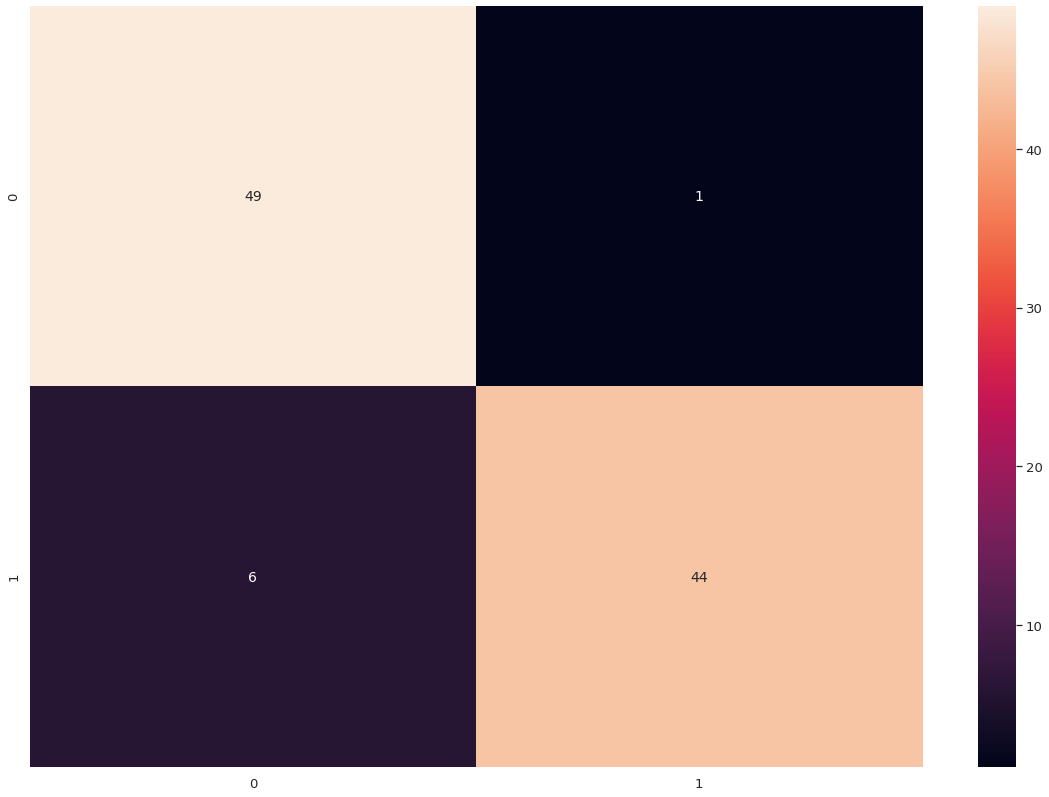

In [119]:
import seaborn as sn
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, range(2), range(2))
plt.figure(figsize=(20,14))
sn.set(font_scale=1.2) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 14}, fmt='g') # for num predict size

plt.show()

In [120]:
label_dict = output_tokenizer.word_index

In [121]:
label = [key for key, value in label_dict.items()]



> แสดง Precision, Recall, F1-score



In [122]:
print(classification_report(y_true, predicted_classes, target_names=label, digits=4))

              precision    recall  f1-score   support

         neg     0.8909    0.9800    0.9333        50
         pos     0.9778    0.8800    0.9263        50

    accuracy                         0.9300       100
   macro avg     0.9343    0.9300    0.9298       100
weighted avg     0.9343    0.9300    0.9298       100



**Word2Vec Transfer Learning ด้วย gensim**




In [123]:
pip install --upgrade gensim

> Import Package ที่จำเป็น การทำ W2V Tranfer Learning ด้วย gensim

In [124]:
from gensim.models import Word2Vec

In [125]:
dimension = 128

In [126]:
sentences = [st.split() for st in cleaned_words]

In [127]:
w2v_model = Word2Vec(sentences, min_count=1, vector_size=dimension, workers=6, sg=1, epochs=1000)

In [128]:
w2v_model.save('w2v_model_gs.bin')

In [129]:
new_model = Word2Vec.load('w2v_model_gs.bin')

> นิยาม Model แบบ Gensim

*   กำหนด learning_rate=0.0001
*   กำหนด dropout = 0.3


In [130]:
embedding_matrix = np.zeros((vocab_size, dimension))

for word, i in train_word_tokenizer.word_index.items():
    if word in new_model.wv.key_to_index:
        embedding_vector = new_model.wv[word]
        embedding_matrix[i] = embedding_vector
adam = Adam(learning_rate=0.0001)

def create_model(vocab_size, max_length):
  model = Sequential()
  
  model.add(Embedding(vocab_size, dimension, input_length = max_length, trainable = False, weights=[embedding_matrix]))
  model.add(Bidirectional(GRU(128, activation = "relu")))
  model.add(Dense(128, activation = "relu"))
  model.add(Dropout(0.3))
  model.add(Dense(64, activation = "relu"))
  model.add(Dropout(0.3))
  model.add(BatchNormalization())
  model.add(Dense(num_classes, activation = "softmax"))
  
  return model
  
model = create_model(vocab_size, max_length)

In [131]:
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 65, 128)           202496    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               198144    
_________________________________________________________________
dense_9 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 64)               


> สร้างจุด Check Point เพื่อ Save Model



In [132]:
filename = 'model.h5_gs'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')



> Train Model



In [133]:
hist = model.fit(train_X, train_Y, epochs = EPOCHS, batch_size = BS, validation_data = (val_X, val_Y), callbacks = [checkpoint])

Epoch 1/150
13/13 [==============================] - 6s 270ms/step - loss: 0.9967 - accuracy: 0.5075 - val_loss: 0.6999 - val_accuracy: 0.4500

Epoch 00001: val_loss improved from inf to 0.69992, saving model to model.h5_gs
INFO:tensorflow:Assets written to: model.h5_gs/assets
Epoch 2/150
13/13 [==============================] - 3s 245ms/step - loss: 0.8949 - accuracy: 0.5200 - val_loss: 0.6884 - val_accuracy: 0.5700

Epoch 00002: val_loss improved from 0.69992 to 0.68844, saving model to model.h5_gs
INFO:tensorflow:Assets written to: model.h5_gs/assets
Epoch 3/150
13/13 [==============================] - 3s 235ms/step - loss: 0.7848 - accuracy: 0.5850 - val_loss: 0.6777 - val_accuracy: 0.6000

Epoch 00003: val_loss improved from 0.68844 to 0.67773, saving model to model.h5_gs
INFO:tensorflow:Assets written to: model.h5_gs/assets
Epoch 4/150
13/13 [==============================] - 3s 242ms/step - loss: 0.6879 - accuracy: 0.6325 - val_loss: 0.6667 - val_accuracy: 0.6900

Epoch 00004: v



> Save History



In [134]:
with open('history_model_gs', 'wb') as file:
    p.dump(hist.history, file)


> Load History



In [135]:
with open('history_model_gs', 'rb') as file:
    his = p.load(file)


> Plot Loss และ Validate Loss


In [136]:
h1 = go.Scatter(y=his['loss'], 
                    mode="lines", line=dict(
                    width=2,
                    color='blue'),
                    name="loss"
                   )
h2 = go.Scatter(y=his['val_loss'], 
                    mode="lines", line=dict(
                    width=2,
                    color='red'),
                    name="val_loss"
                   )

data = [h1,h2]
layout1 = go.Layout(title='Loss',
                   xaxis=dict(title='epochs'),
                   yaxis=dict(title=''))
fig1 = go.Figure(data = data, layout=layout1)
plotly.offline.iplot(fig1, filename="Intent Classification")


> Plot Accuracy และ Validate Accuracy



In [137]:
h1 = go.Scatter(y=his['accuracy'], 
                    mode="lines", line=dict(
                    width=2,
                    color='blue'),
                    name="acc"
                   )
h2 = go.Scatter(y=his['val_accuracy'], 
                    mode="lines", line=dict(
                    width=2,
                    color='red'),
                    name="val_acc"
                   )

data = [h1,h2]
layout1 = go.Layout(title='Accuracy',
                   xaxis=dict(title='epochs'),
                   yaxis=dict(title=''))
fig1 = go.Figure(data = data, layout=layout1)
plotly.offline.iplot(fig1, filename="Intent Classification")

In [138]:
predict_model = load_model(filename) 
predict_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 65, 128)           202496    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               198144    
_________________________________________________________________
dense_9 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 64)               

In [139]:
score = predict_model.evaluate(val_X, val_Y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.10584022849798203
Test accuracy: 0.9700000286102295


In [140]:
predicted_classes = predict_model.predict_classes(val_X)
predicted_classes.shape

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning:

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).



(100,)

In [141]:
y_true = np.argmax(val_Y,axis = 1)
print(val_Y[0])
print(y_true[0])

[1. 0.]
0




> Save Confusion Matrix



In [142]:
cm = confusion_matrix(y_true, predicted_classes)
np.savetxt("confusion_matrix_gs.csv", cm, delimiter=",")


> Plot Confusion Matrix



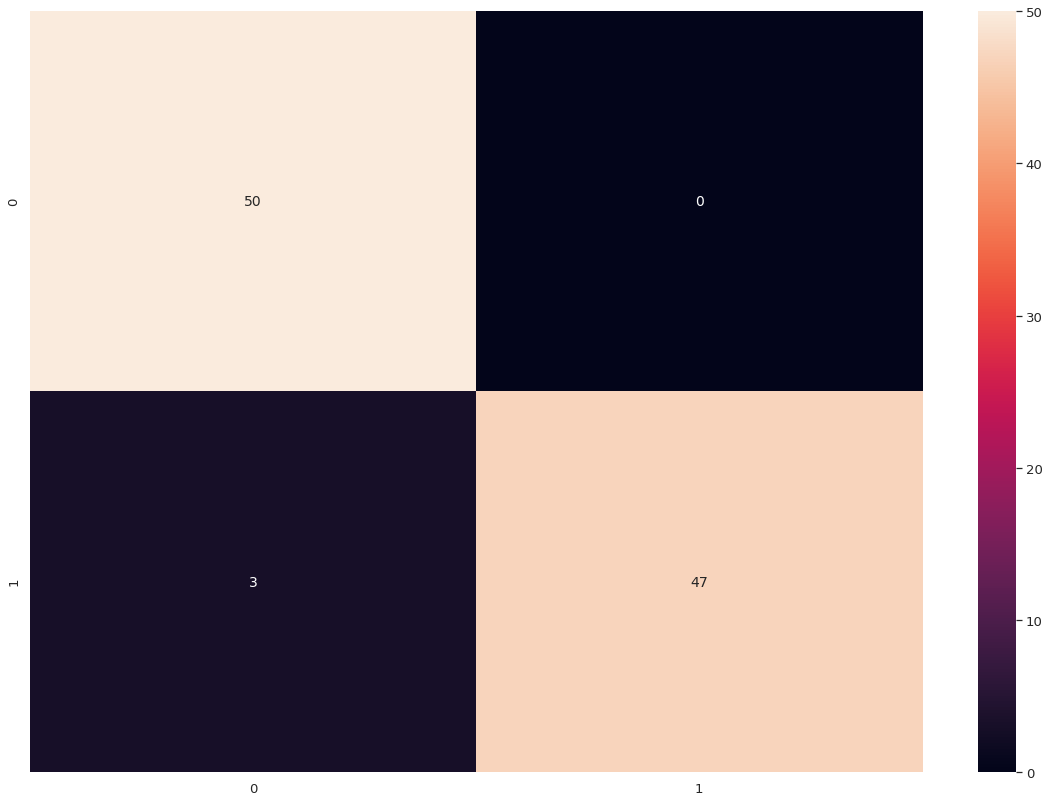

In [143]:
import seaborn as sn
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, range(2), range(2))
plt.figure(figsize=(20,14))
sn.set(font_scale=1.2) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 14}, fmt='g') # for num predict size

plt.show()

In [144]:
label_dict = output_tokenizer.word_index

In [145]:
label = [key for key, value in label_dict.items()]



> แสดง Precision, Recall, F1-score



In [146]:
print(classification_report(y_true, predicted_classes, target_names=label, digits=4))

              precision    recall  f1-score   support

         neg     0.9434    1.0000    0.9709        50
         pos     1.0000    0.9400    0.9691        50

    accuracy                         0.9700       100
   macro avg     0.9717    0.9700    0.9700       100
weighted avg     0.9717    0.9700    0.9700       100

